<a href="https://colab.research.google.com/github/BryanDYang/Optiver_Trading/blob/main/Optiver_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optiver: Trading at the Close

The Nasdaq Stock Exchange closes each day with the Nasdaq Closing Cross auction. Using historic data for the daily ten minute closing auction, our goal in this project is to build a model that predicts the future price movements of stocks.

## Import Library

In [ ]:
# For Kaggle

# Standard Libraries
import sys
import os
import collections
import re
import datetime as dt
import glob
from collections import Counter

# Data Science Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
import seaborn as sns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn as sk
import lightgbm
import xgboost
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Project Libraries
#import optiver2023

# Configure Visualization
%matplotlib inline
plt.style.use('bmh')

# Configure Pandas and SKLearn
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.precision", 3)
sk.set_config(display="diagram")

# File Specific Configurations
DATA_DIR = "/kaggle/input/optiver-trading-at-the-close/"
plt.rcParams['figure.dpi'] = 270
START = pd.Timestamp.now()
SEED = 42

## Import Data

In [ ]:
%%capture
!apt update
!pip install --upgrade kaggle

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle competitions download optiver-trading-at-the-close

 97% 194M/201M [00:02<00:00, 101MB/s] 
100% 201M/201M [00:02<00:00, 98.7MB/s]


In [ ]:
!unzip optiver-trading-at-the-close.zip

Archive:  optiver-trading-at-the-close.zip
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: optiver2023/__init__.py  
  inflating: optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv("train.csv")
train_df = train_df.dropna(subset=["target"])
train_df.reset_index(drop=True, inplace=True)
train_df.shape

(5237892, 17)

## Exploratory Data Analysis (EDA)



<div class="alert alert-block alert-info">
<h2 style="text-align:center;">About 'train.csv'</h2>
<b> stock_id -</b> A unique identifier for the stock. Not all stock IDs exist in every time bucket.
<br><b> date_id -</b> A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
<br><b> imbalance_size -</b> The amount unmatched at the current reference price (in USD).
<br><b> imbalance_buy_sell_flag -</b> An indicator reflecting the direction of auction imbalance.
<br><b> reference_price -</b> The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order.
<br><b> matched_size -</b> The amount that can be matched at the current reference price (in USD).
<br><b> far_price -</b> The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
<br><b> near_price -</b> The crossing price that will maximize the number of shares matched based auction and continuous market orders.
<br><b> [bid/ask]_price -</b> Price of the most competitive buy/sell level in the non-auction book.
<br><b> [bid/ask]_size -</b> The dollar notional amount on the most competitive buy/sell level in the non-auction book.
<br><b> wap -</b> The weighted average price in the non-auction book.
<br><b> seconds_in_bucket -</b> The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
<br><b> target -</b> The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.                   
</div>

Using the describe function, we are able to view statistical data of our dataset.  

In [ ]:
train_df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,2.344e+06,2.381e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06
mean,9.929e+01,2.415e+02,2.700e+02,5.715e+06,-1.190e-02,1.000e+00,4.510e+07,1.002e+00,9.997e-01,9.997e-01,5.181e+04,1.000e+00,5.358e+04,1.000e+00,-4.756e-02,1.331e+04
std,5.787e+01,1.385e+02,1.587e+02,2.052e+07,8.853e-01,2.532e-03,1.398e+08,7.215e-01,1.217e-02,2.499e-03,1.114e+05,2.510e-03,1.294e+05,2.498e-03,9.453e+00,7.619e+03
min,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-1.000e+00,9.353e-01,4.317e+03,7.700e-05,7.870e-01,9.349e-01,5.600e-01,9.398e-01,5.900e-01,9.380e-01,-3.853e+02,0.000e+00
25%,4.900e+01,1.220e+02,1.300e+02,8.453e+04,-1.000e+00,9.988e-01,5.280e+06,9.963e-01,9.971e-01,9.985e-01,7.375e+03,9.990e-01,7.824e+03,9.988e-01,-4.560e+00,6.729e+03
50%,9.900e+01,2.420e+02,2.700e+02,1.114e+06,0.000e+00,1.000e+00,1.288e+07,9.999e-01,9.999e-01,9.997e-01,2.197e+04,1.000e+00,2.302e+04,1.000e+00,-6.020e-02,1.334e+04
75%,1.490e+02,3.610e+02,4.100e+02,4.191e+06,1.000e+00,1.001e+00,3.270e+07,1.003e+00,1.003e+00,1.001e+00,5.583e+04,1.001e+00,5.788e+04,1.001e+00,4.410e+00,1.991e+04
max,1.990e+02,4.800e+02,5.400e+02,2.982e+09,1.000e+00,1.077e+00,7.714e+09,4.380e+02,1.310e+00,1.077e+00,3.029e+07,1.078e+00,5.440e+07,1.078e+00,4.461e+02,2.645e+04


However, we would like to go beyond that and use this helper function to give us a better sense of aspects like uniqueness and cardinality.

In [ ]:
def inspect_columns(df):
    # A helper function that does a better job than df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

In [ ]:
inspect_columns(train_df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,6,199,int64
date_id,False,481,False,0.00,0,60,480,int64
seconds_in_bucket,False,55,False,0.00,0,520,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,0.0,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,0,-1,int64
reference_price,False,28741,True,0.00,1.0,0.999,1.002,float64
matched_size,False,2948862,True,0.00,13380276.64,8523863.73,24073677.32,float64
far_price,False,95739,True,55.26,NaN,0.999,1.001,float64
near_price,False,84625,True,54.55,NaN,0.999,1.001,float64
bid_price,False,28313,True,0.00,1.0,0.999,1.002,float64


Based on these snapshots of the data, we observe the following.

The cardinality of stock_id, date_id, and seconds_in_buckets multiplied together — 200 * 481 * 55 = 5,291,000 — is roughly equal to the number of total rows.

Narrowing in on this, we assume that the training data consists of 200 * 481 = 96,200 time series and that each time series is 55 steps long. Note that each time series represents the last 10 minutes of a stock on a trading date.

Additionally, in our calculation we have 5,291,000 [something] and our describe function have us a count of 5,237,980. This means we have some missing data. While the Kaggle competition deems this normal in the Dataset Description — not all stock IDs exist in every time bucket — we will further explore what kind of data we are missing.

time_id is an ID for the permutation of seconds_in_bucket and date_id.

row_id is a string concatenation of date_id, seconds_in_bucket, and stock_id, separated with underscores.

target is the target variable we want to predict.

Other columns are the features (or covariate in terms of Time Series ML).

In [ ]:
# Take a look at any single time series by setting the stock_id and date_id

stock_id = 6
date_id = 4

(train_df
    .query(f'stock_id == {stock_id} & date_id == {date_id}')
    .drop(columns=['stock_id', 'date_id', 'time_id', 'row_id'])
    .head(10)
)

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
42026,0,126061.42,-1,1.000,4.550e+06,NaN,NaN,1.000,1443.36,1.001,29387.97,1.000,-7.84
42218,10,70729.12,-1,0.999,4.605e+06,NaN,NaN,0.998,48012.00,1.000,48095.00,0.999,5.97
42410,20,65917.61,-1,0.999,4.610e+06,NaN,NaN,0.998,480.13,1.000,48095.00,0.998,16.19
42602,30,100079.30,-1,0.998,4.610e+06,NaN,NaN,0.998,48014.00,1.000,15870.03,0.999,2.18
42794,40,0.00,0,0.999,4.710e+06,NaN,NaN,0.999,6727.70,1.000,2887.32,1.000,-4.70
42986,50,0.00,0,0.999,4.710e+06,NaN,NaN,0.999,14417.40,1.000,4811.80,1.000,-2.91
43178,60,0.00,0,0.999,4.710e+06,NaN,NaN,0.999,4805.80,1.000,5292.98,0.999,-14.79
43370,70,0.00,0,0.999,4.713e+06,NaN,NaN,0.999,4805.80,1.000,5292.98,0.999,-12.59
43562,80,0.00,0,0.999,4.713e+06,NaN,NaN,0.999,4805.80,1.000,5292.98,0.999,-5.46
43754,90,0.00,0,0.999,4.713e+06,NaN,NaN,0.999,4805.80,1.000,7698.88,0.999,-10.62


### What type of data are missing?

There are 3 types of data we could be missing when it comes to our time series:

1. An entire time series (e.g., some stocks have no data at all on some days)

2. Steps of a time series (e.g., some time series have fewer than 55 steps)

3. A combination of 1 and 2

**The answer to these questions are crucial to our later model building.**

In [ ]:
# Let's first exam if all the time series are 55 steps long

(train_df
    .groupby(['stock_id', 'date_id'])
    ['seconds_in_bucket'] # Extract the column of interest
    .count() # Count the number of rows in each permutation of stock_id and date_id
    .apply(lambda x: x == 55) # Check if every count is 55
    .all() # Check if all the booleans are True
)

False

The above result suggests that all the time series in our training data are of not the same length of 55.

Therefore, it can be concluded that **there are some stocks missing data on some days and seconds**.

Many time series each with a few irregular lose steps are way harder to deal with than a few time series missing entirely while other time series are whole.

Unfortunately, that kind of problem is the case here.

Next, let's keep exploring which stocks are missing data on which days?

In [ ]:
all_stock_id = np.sort(train_df["stock_id"].unique())
print(all_stock_id[:10])
print(all_stock_id[-10:])

[0 1 2 3 4 5 6 7 8 9]
[190 191 192 193 194 195 196 197 198 199]


In [ ]:
all_date_id = np.sort(train_df["date_id"].unique())
print(all_date_id[:10])
print(all_date_id[-10:])

[0 1 2 3 4 5 6 7 8 9]
[471 472 473 474 475 476 477 478 479 480]


In [ ]:
# Make a MultiIndex object from the cartesian product of all possible combinations.
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id],
    names=["date_id", "stock_id"]
)

# To get the all missing data.
# join the MultiIndex with the Trianing data,
# and then filter out all the rows that are not in the training data.
missing_data = (train_df
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True) # Add a new column to indicate if the row is in the training data
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()") # Filter out the missing data
    .set_index("stock_id", drop=True)
    ["date_id"]
)

# A Series object for missing data
missing_data

stock_id
69       0
78       0
79       0
102      0
135      0
      ... 
102    292
102    293
102    294
73     320
158    388
Name: date_id, Length: 965, dtype: int64

In [ ]:
# Show all the stock_id that have at least 1 day of missing data
missing_data.index.unique()

Int64Index([69, 78, 79, 102, 135, 150, 153, 156, 199, 99, 73, 158], dtype='int64', name='stock_id')

In [ ]:
# See which date's data are missing for a specific stock_id
stock_id = 78 # change this
missing_data[stock_id]

stock_id
78    0
78    1
78    2
78    3
Name: date_id, dtype: int64

In [ ]:
# A summary of the of missing date counts for each stock_id
missing_data.groupby("stock_id").count().sort_values()

stock_id
73       1
99       1
158      1
78       4
69      37
156     37
150     59
153     70
199     88
79     181
135    191
102    295
Name: date_id, dtype: int64

`stock_id = 73` is missing 1 day of data, and `stock_id = 102` is missing 295 days of data, and so forth.

### Understanding the Features

In [ ]:
def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

#### Order book

We need to first understand the concept of **Order book** to understand following features:

- `bid_price`
- `ask_price`
- `bid_size`
- `ask_size`
- `wap`

So, what is an order book?

![](https://i.ibb.co/sqVfdLm/order-book-1.png)

Above picture is a demo of an Order Book,

- We can see that at a price level of 9 there are 2 shares on the **bid**, meaning the market participants are willing to **buy** 2 shares for a price of 9.

- We can also see that at a price level of 10 there is 1 share on the **ask**, meaning market participants are willing to **sell** 1 share for a price of 10.

![](https://i.ibb.co/WHMX37t/order-book-2.png)

If someone were to put in an ask of 10 shares at a price of 9, then 2 shares would be **matched**. The new best ask would be 8 shares at a price of 9, the new state of the book is displayed above.

-----

According to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data):

- `bid_price` & `ask_price` - Price of the most competitive buy/sell level in the non-auction book.

- `bid_size` & `ask_size` - The _dollar notional_ amount on the most competitive buy/sell level in the non-auction book.

- `wap` - The weighted average price in the non-auction book.

$$
\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize}
$$

Other than `wap`, the other 4 features are self-explanatory.

To understand `wap` _intuitively_, we have did some researches on the formula and found the following properties:

- `wap` is always larger than `bid_price` and smaller `ask_price`.

- If `bid_size` is larger than `ask_size`, then `wap` would be closer to `ask_price`, and vice versa.

In other words, an increase in `bid_size` / `ask_size` would "push" the `wap` toward opposite direction, but `wap` would always stays in the gap between `bid_price` and `ask_price`.

**Basically, `wap` serve as a decent guess of the _fair price_ of a stock**: If the `bid_size` increase, the buyers are more aggressive, so the _fair price_ should be closer to the `ask_price`. It makes intuitive sense, right?

Now we draw some time series plots to confirm our speculations:

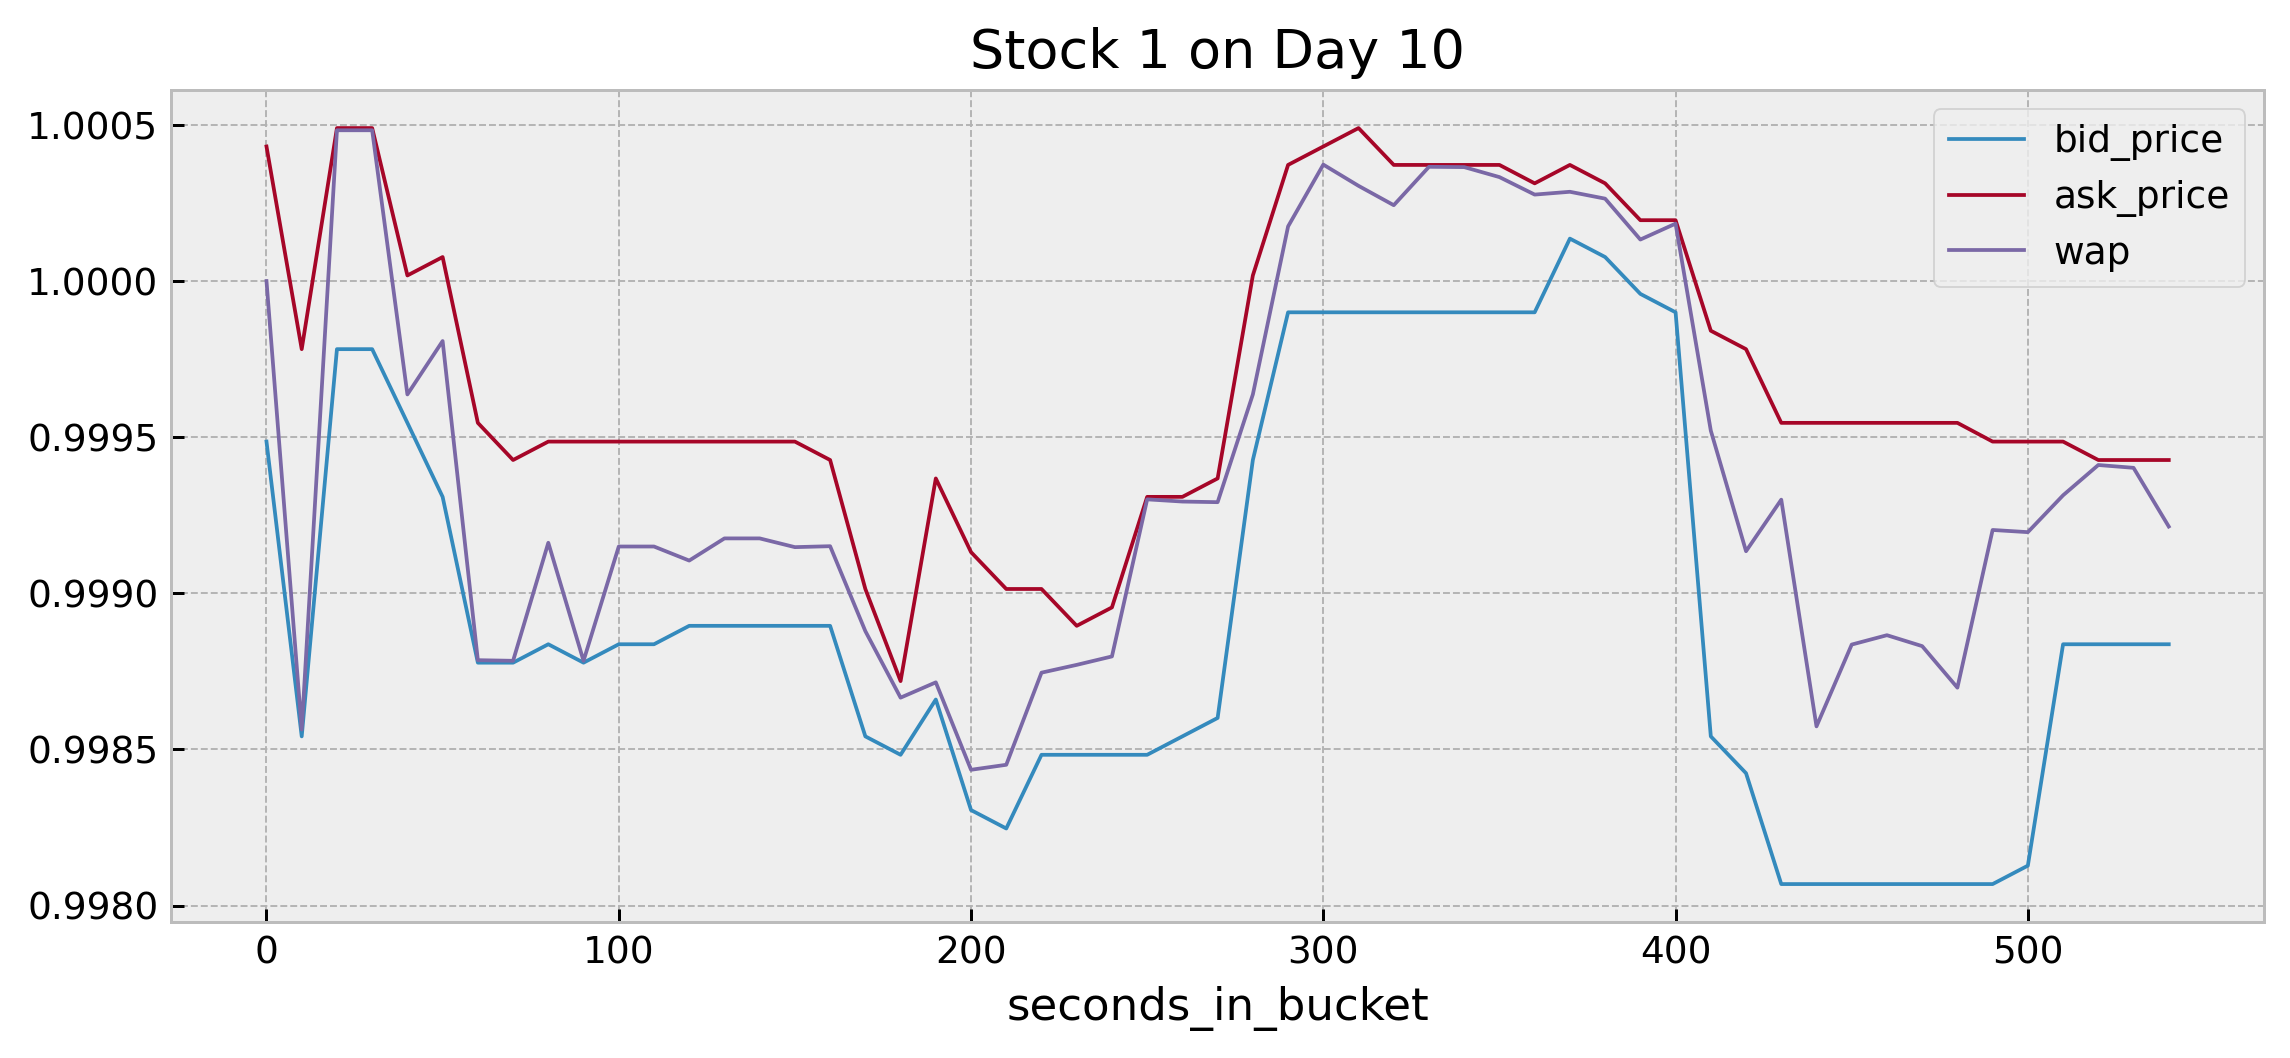

In [ ]:
# We tried a few different stock_id and date_id to see the common patterns

time_series_plot(
    df=train_df,
    cols=['bid_price','ask_price', 'wap'],
    stock_id = 1,
    date_id = 10
)

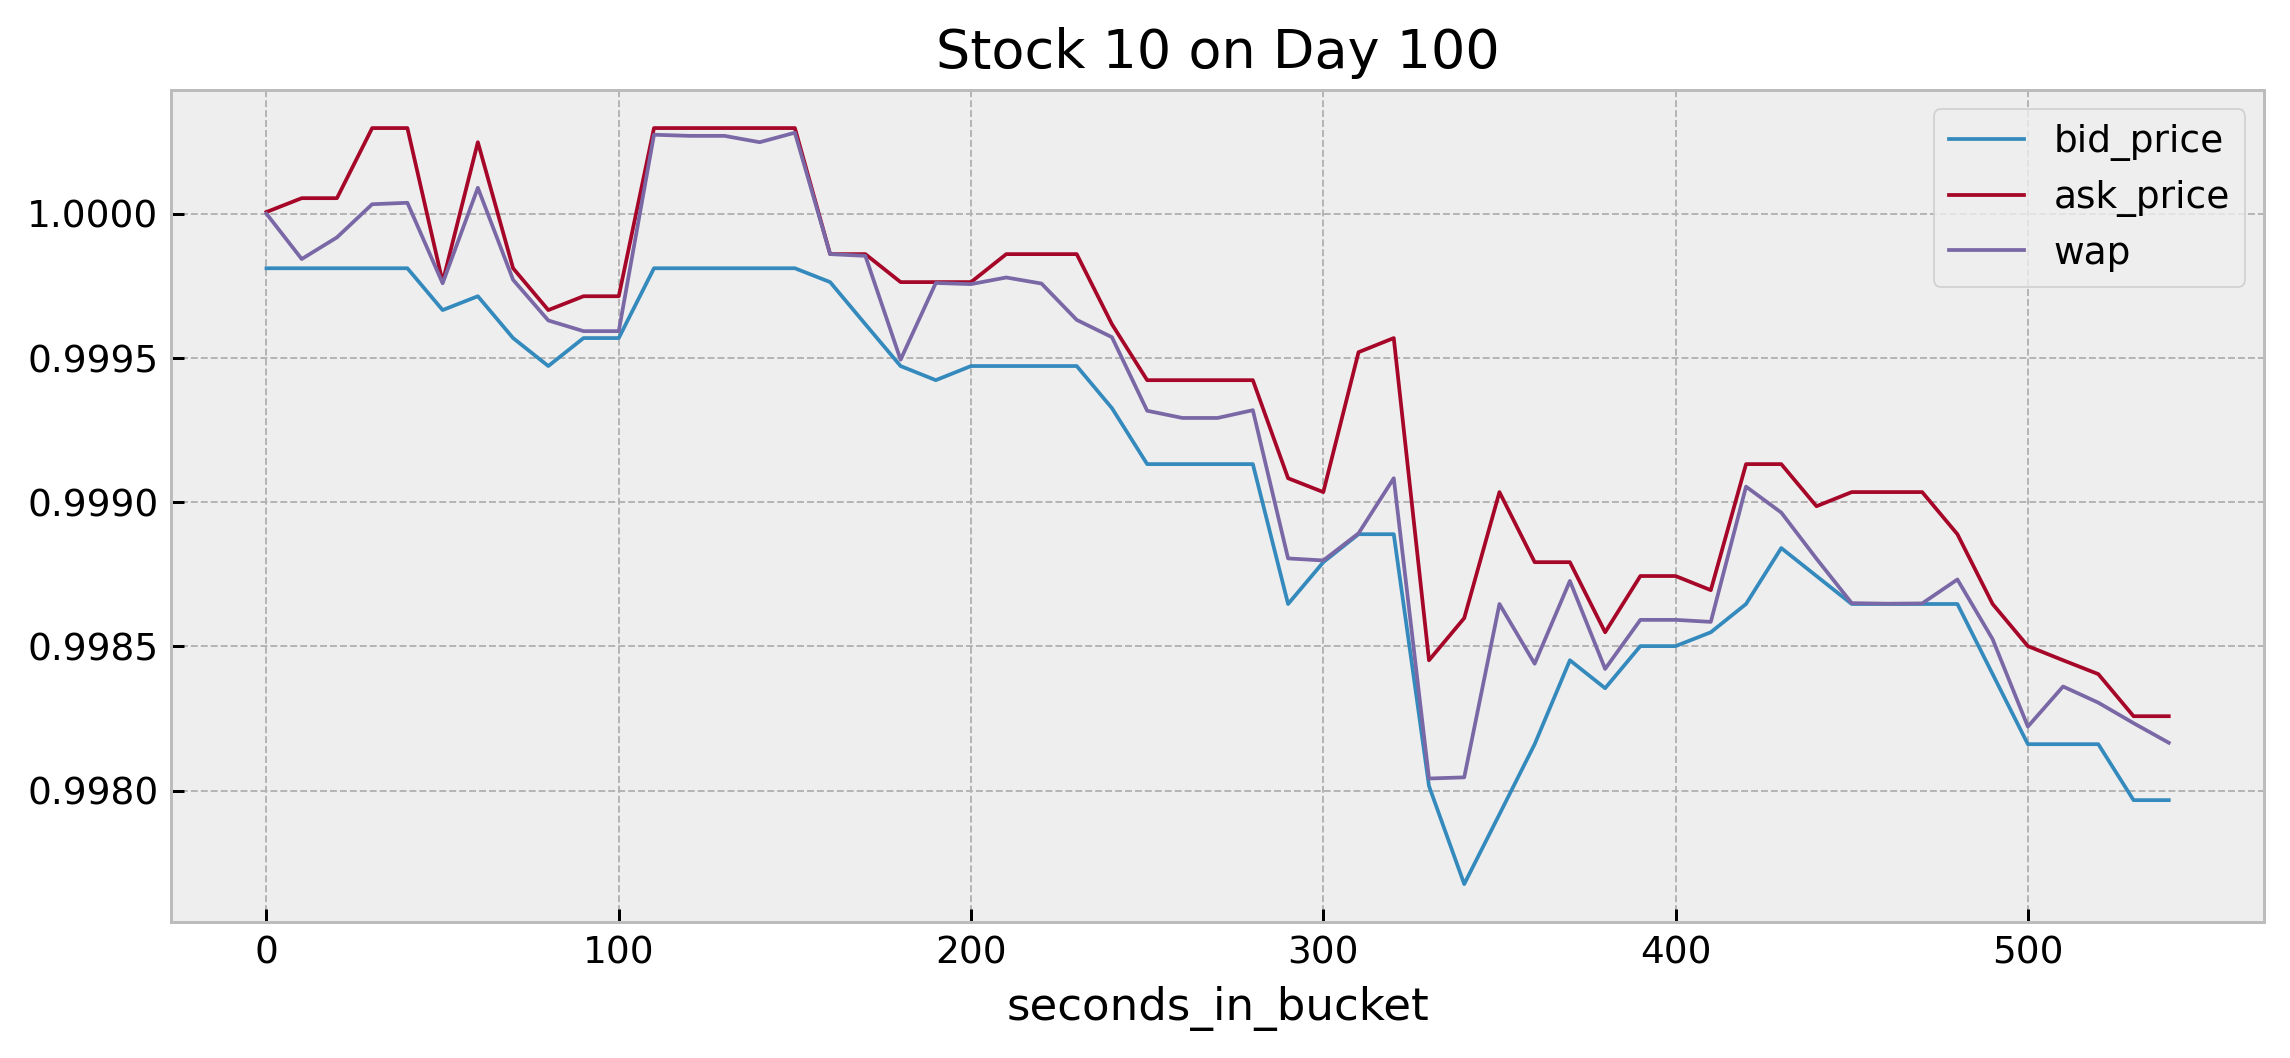

In [ ]:
# Another example

time_series_plot(
    df=train_df,
    cols=['bid_price','ask_price', 'wap'],
    stock_id = 10,
    date_id = 100
)

**Note:** all the prices shown here are converted to a price move relative to the stock `wap` (weighted average price) at the beginning of the auction period.

#### Auction Order Book

The concept of **Auction Order Book** is the key to understand the follwoing features:

- `imbalance_size`
- `imbalance_buy_sell_flag`
- `matched_size`
- `far_price`

So, what is an Auction Order Book? And how it differ from an (oridinary) Order Book?

**In an Auction Order Book, the orders are not immediately matched, but instead collected until the moment the auction ends.**

![](https://i.ibb.co/HFjZQV9/order-book-3.png)

In the above example, the book is referred to as **in cross**, since the best bid and ask are overlapping.

Suppose the auction ends with the book in this state, then:

- At a price of 10, 0 lots would be matched since there as no bids >= 10.

- At a price of 9, 3 lots would be matched, as there are 3 bids >=9 and 6 asks <= 9.

- At a price of 8, 4 lots would be matched, since are 7 bids>=8, and there are 4 asks<=8.

So the price which _maximizes_ the number of matched lots would be 8. In the situation like this, We would describe the Auction Order Nook in the following way:

- The **uncross price** is 8
- The **matched size** would be 4
- There are 3 Bids (7 - 4 = 3) are still unmatched, therefore, the **imbalance** would be 3 lots in the buy direction.

At any given time, the hypothetical **uncross price** (assuming the auction ends immediately) is defined as the current **far price**.

In other words, the **far price** is the price which _maximizes_ the number of matched lots in current status of the Auction Order Book.

Nasdaq provides **far price** information 5 minutes before the closing cross (3:55 p.m.).

Describe the above situtation in terms of our "features", that would be:

- `far_price` = 8
- `matched_size` = 4 * `reference price` (we will explain `reference price` later)
- `imbalance_size` = 3 * `reference price`
- `imbalance_buy_sell_flag` = 1 (1 for buy-side imbalance, -1 for sell-side imbalance, 0 for no imbalance)

Now let's plot some time series:

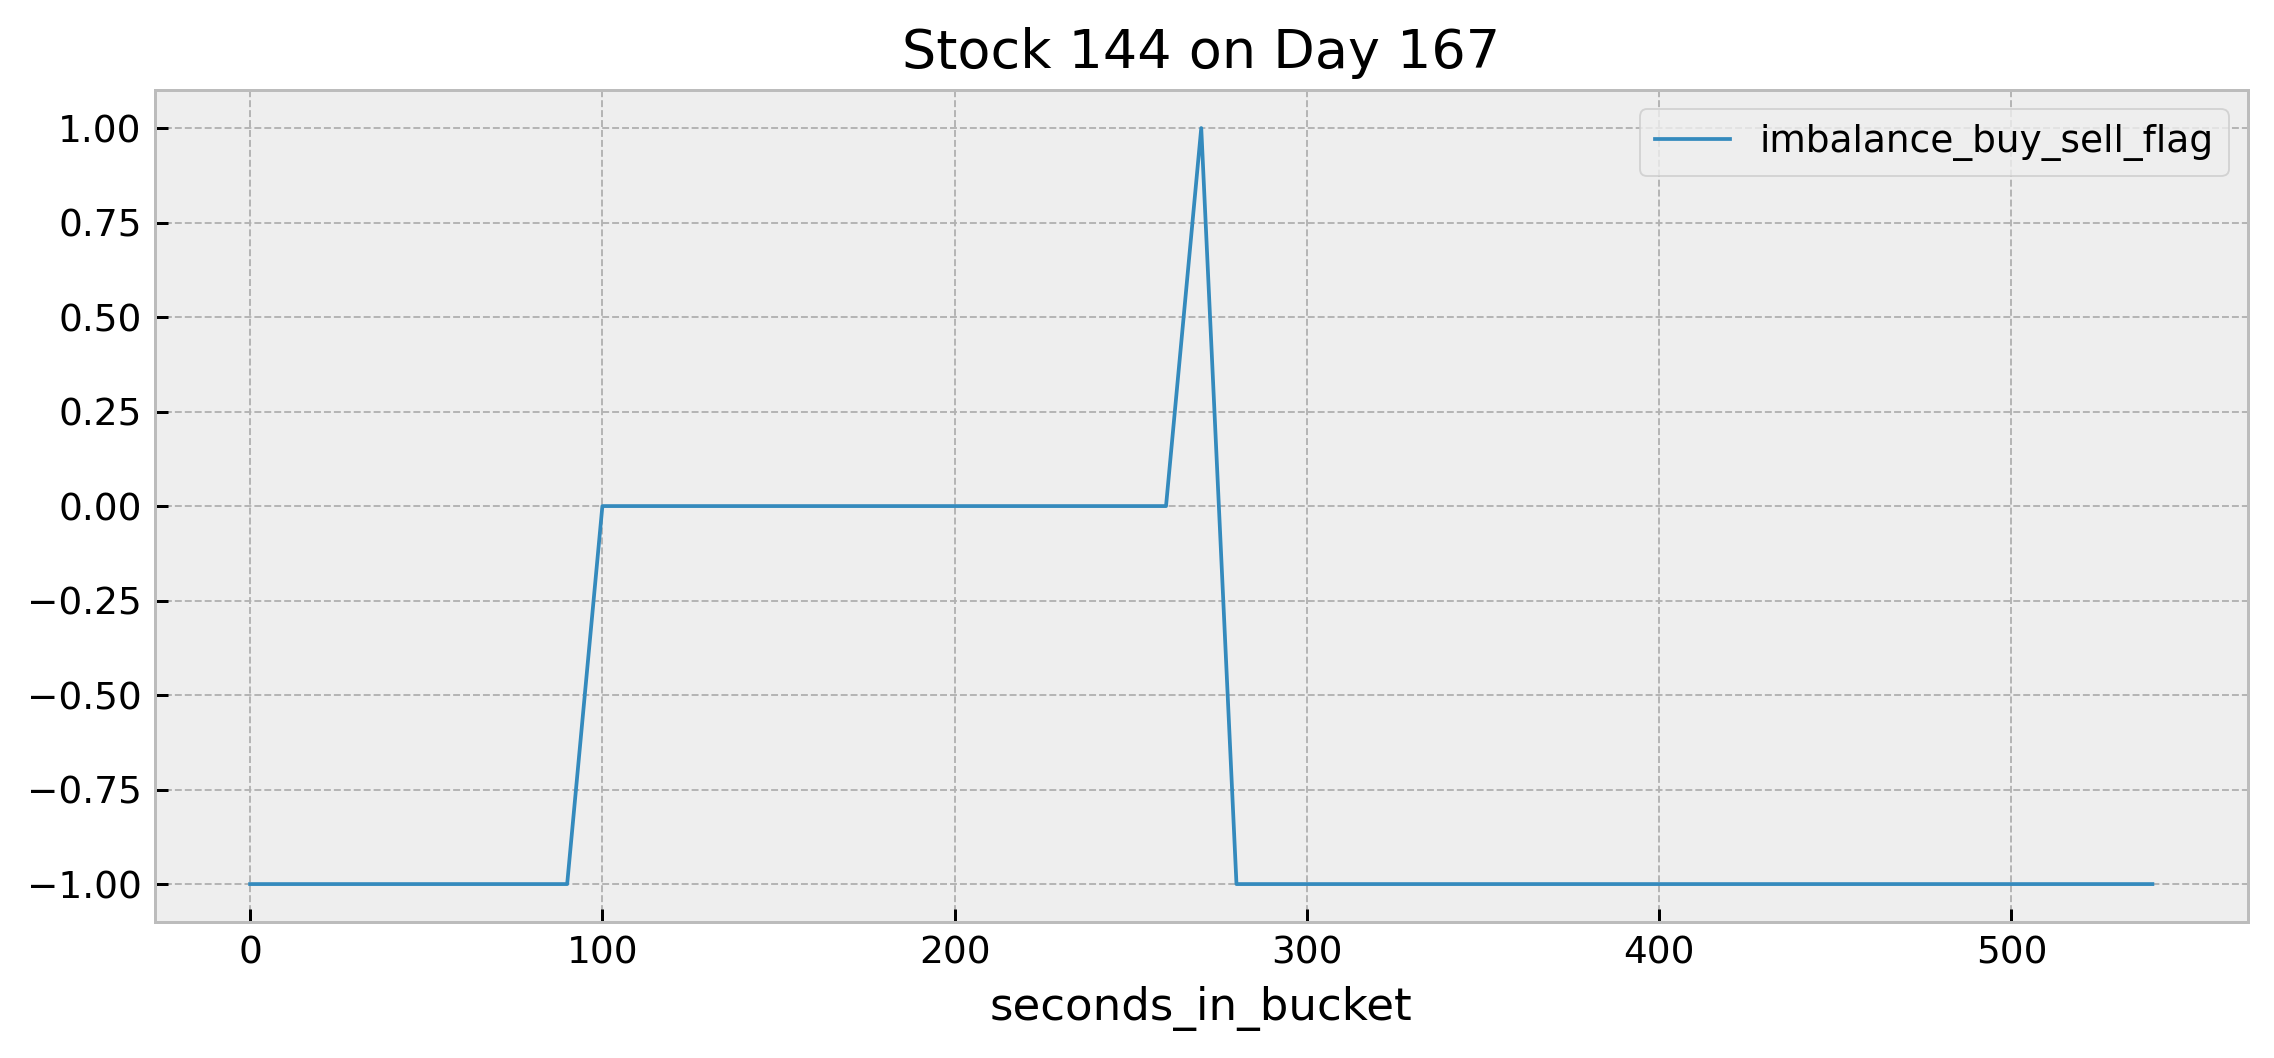

In [ ]:
# To see different random stock_id and date_id, simply run the cell again
time_series_plot(
    df=train_df,
    cols=['imbalance_buy_sell_flag'],
    stock_id = np.random.randint(low=0, high=200),
    date_id = np.random.randint(low=0, high=480),
)

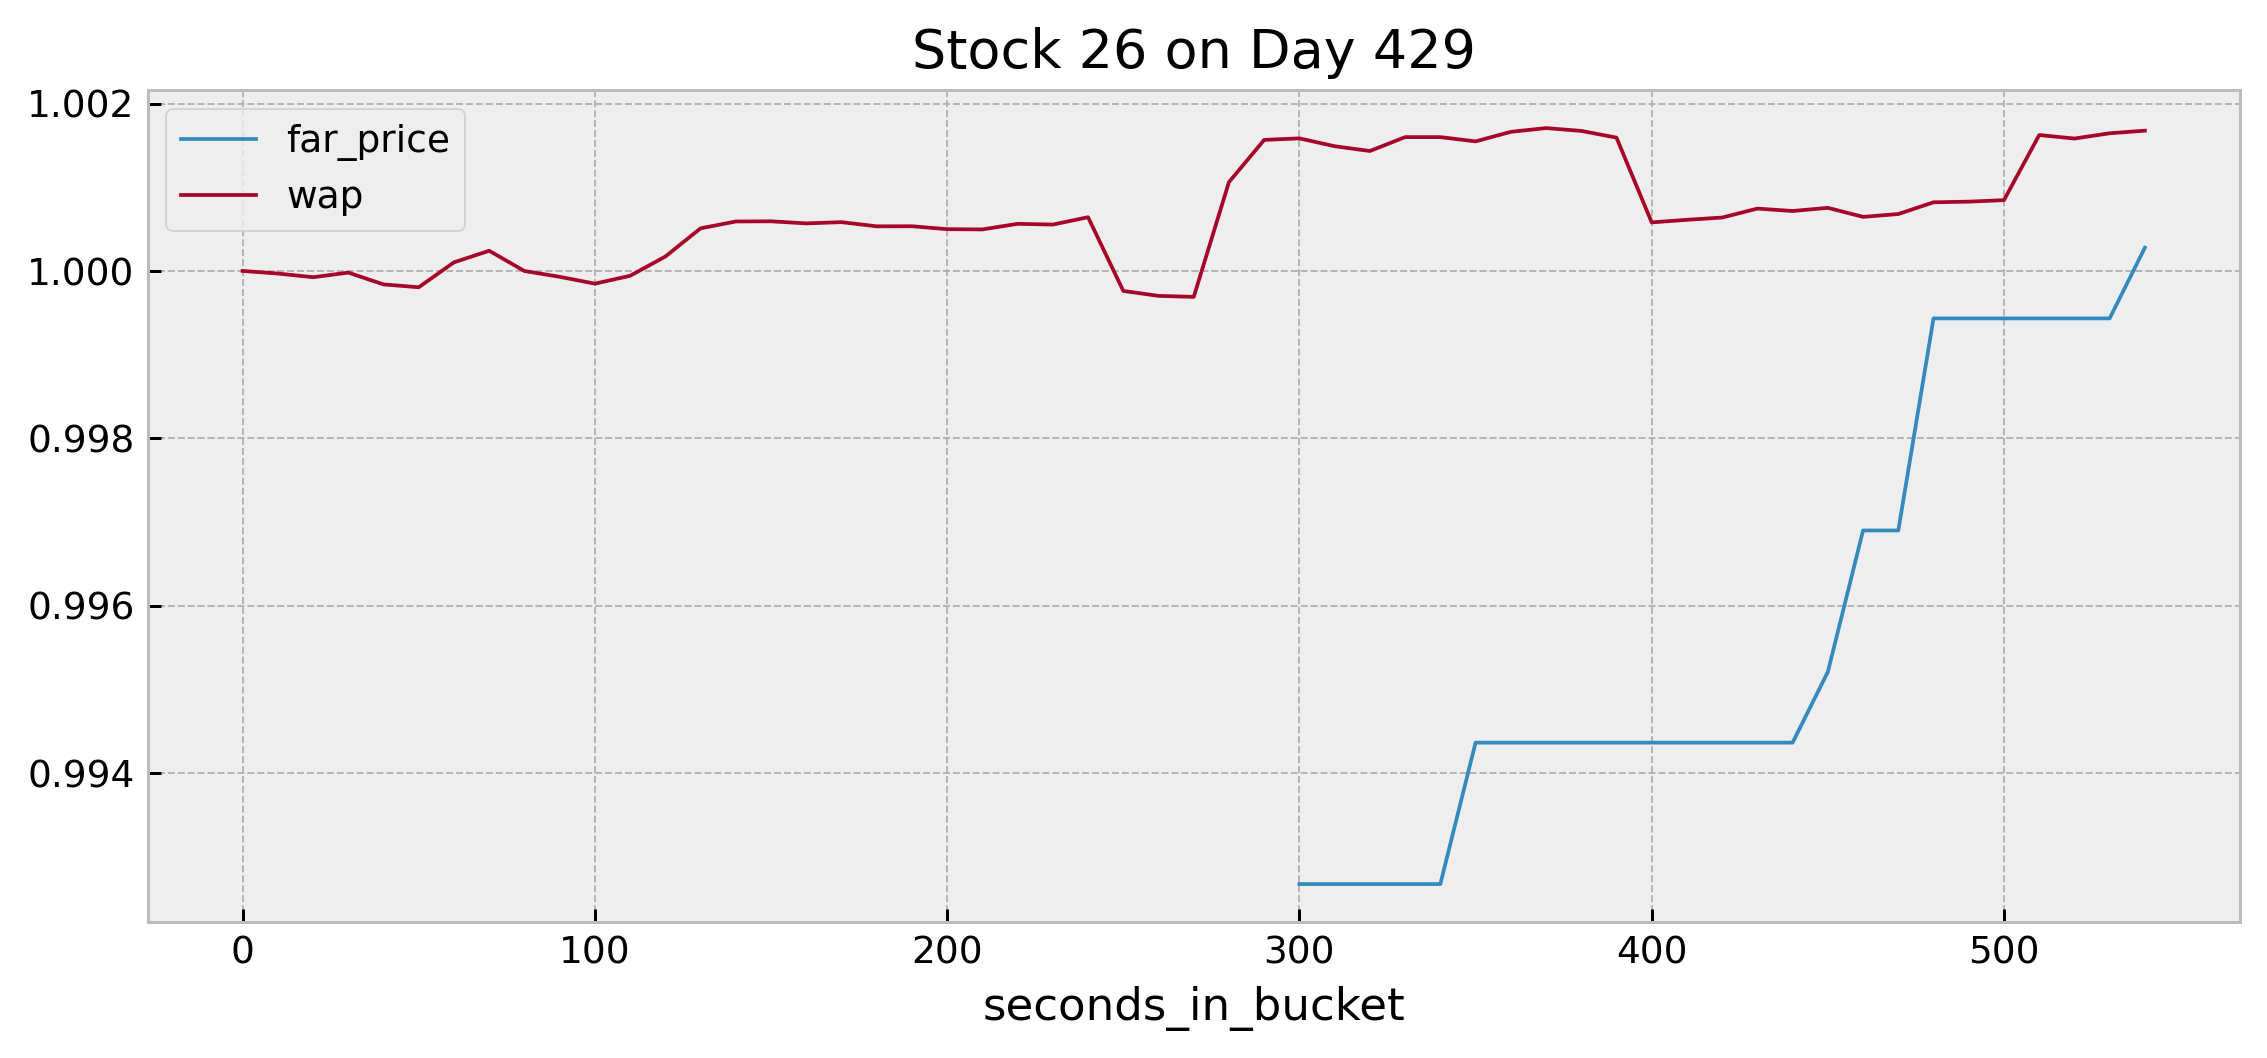

In [ ]:
# Compare the far_price and wap
time_series_plot(
    df=train_df,
    cols=['far_price', 'wap'],
    stock_id = np.random.randint(low=0, high=200),
    date_id = np.random.randint(low=0, high=480),
)

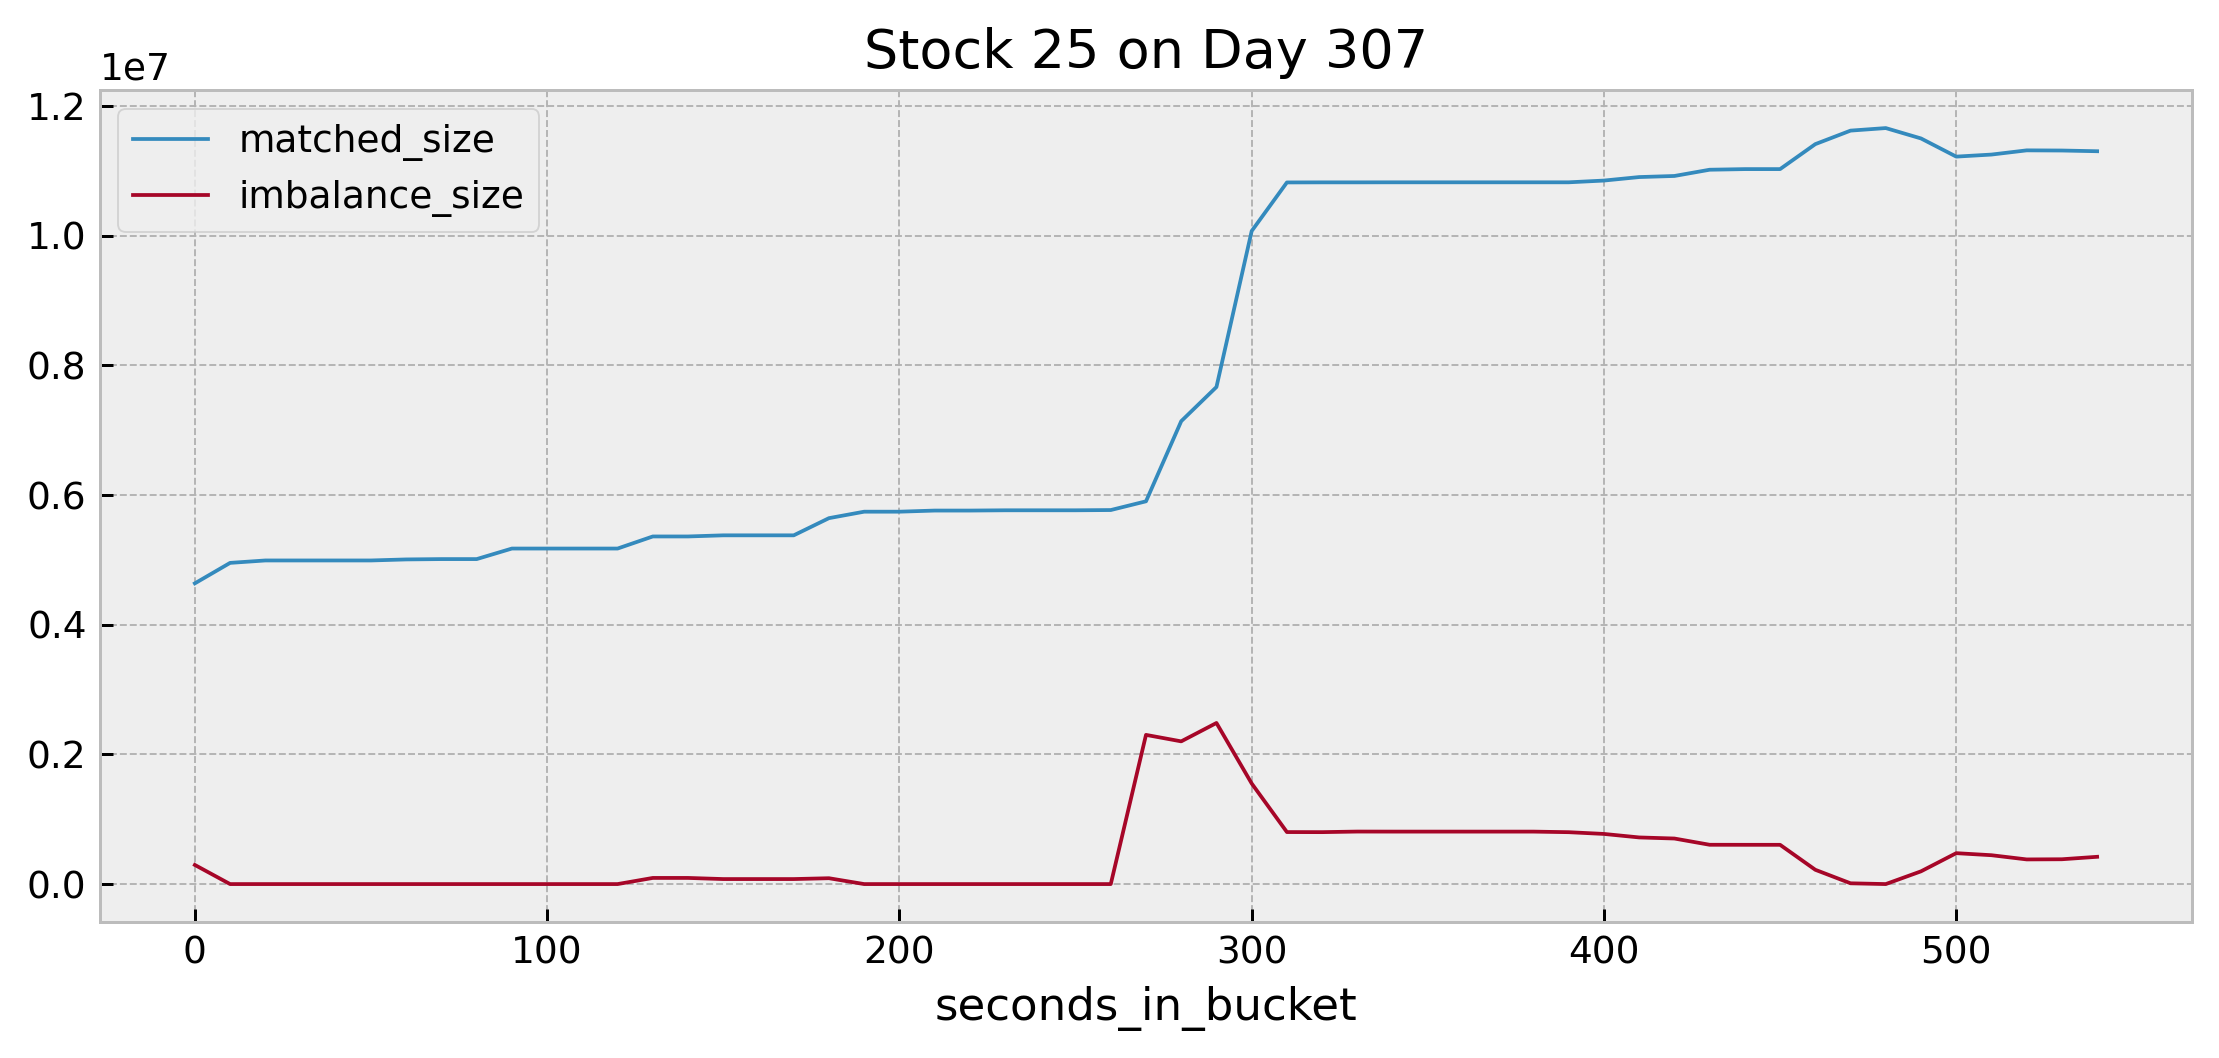

In [ ]:
# Compare the matched_size and imbalance_size
time_series_plot(
    df=train_df,
    cols=['matched_size', 'imbalance_size'],
    stock_id = np.random.randint(low=0, high=200),
    date_id = np.random.randint(low=0, high=480),
)

After plotting the time series for different stock_id and date_id for serval times, we observe a few patterns:

- `Far Price` shows data only after `second_in_bucket`=300, which corresponds to 3:55 p.m.

- `matched_size` and `imbalance_size` significantly diverge at size, after `second_in_bucket`=240 (3:54 p.m.); `imbalance_size` tends to decrease, and `matched_size` tends to increase, after this time point.

#### Combined Book

Finally, the rest 2 features are related to the **Combined Book**, which is the combination of **Order Book** and **Auction Order Book**.

- `reference_price`
- `near_price`

Here we combine our previous order book example & auction book example by aggregating the buying & selling interest across all price levels.

![](https://i.ibb.co/1vPFYwz/order-book-4.png)

For this combined book:

- At a price of 10, 0 lots would be matched, as there are no bids>=10.

- At a price of 9, 5 lots would be matched, as there are 5 bids>=9 and 6 asks <=9.

- At a price of 8, 4 lots would be matched, as there are 9 bids>=8 and 4 asks <=8.

So, the price which maximizes matched lots would be the price of 9. We would therefore describe the combined order book in the following way:

- The uncross price is 9
- The matched size is 5
- The imbalance would be 1 lot, in the sell direction.

The hypothetical uncross price of combined book is called the **near price**.

Same as the **far price**, Nasdaq provides **near price** 5 minutes before the closing cross (3:55 p.m.).

Nasdaq also provides an indication of the fair price called the **reference price**. The reference price is calculated as follows:

- If the near price is between the best bid and ask, then the reference price is equal to the near price

- If the near price > best ask, then reference price = best ask

- If the near price < best bid, then reference price = best bid So the reference price is the near price bounded between the best bid and ask.

Now let's put the `bid_price`, `ask_price`, `wap`, `far_price`, `near_price`, and `reference_price` together:

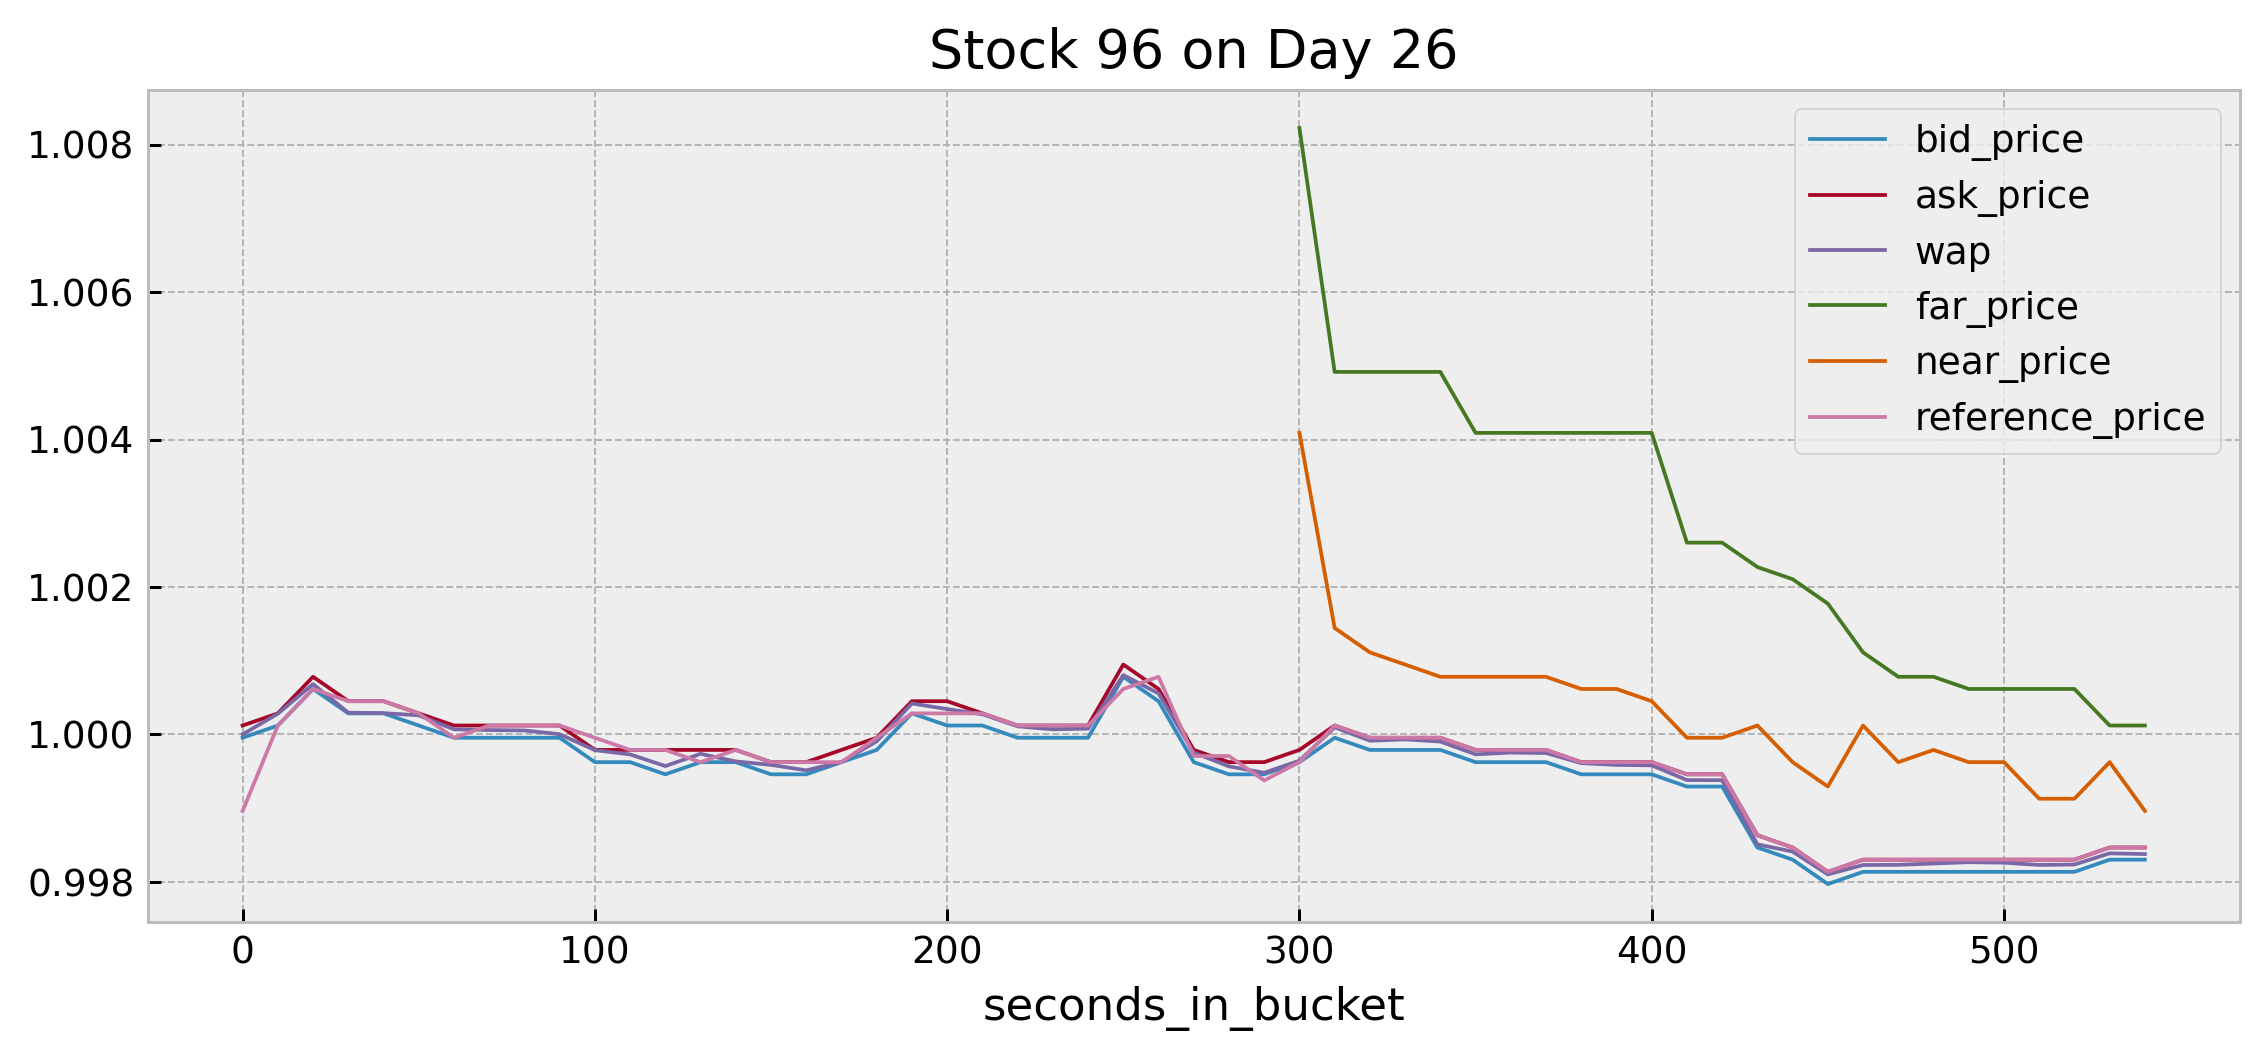

In [ ]:
time_series_plot(
    df=train_df,
    cols=['bid_price', 'ask_price', 'wap', 'far_price', 'near_price', 'reference_price'],
    stock_id = np.random.randint(low=0, high=200),
    date_id = np.random.randint(low=0, high=480),
)

Finally, according to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data), all price related columns are converted to a price move relative to the stock `wap` at the beginning of the auction period.

In other words, the `wap` should be 1 for all beginnings of our Time Series. Let's verify this programatically.

In [ ]:
# Find all wap not equal 1 when seconds_in_bucket == 0
train_df.query("seconds_in_bucket == 0").query('wap != 1')

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id


All the time series do not have wap equal to 1 at the beginning.

### Understand the target (WIP)

> According to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data), `target` is the 60 second future move in the `wap` of the stock, less the 60 second future move of the synthetic index.

### Data Imbalance

## Data Imputation

In this section we will attempt numerous different ways to impute our data. The first will be to replace missing data with a median value. the second is to use data from other columns, the third is to use the value 0, the fourth is [TODO], the fifth is to use a Generative Adversarial Network (GAN).

#### First Attempt - Impute based on median value

In [ ]:
imputer = SimpleImputer(strategy='median') # mean, median, or most_frequent
imputed_df = imputer.fit_transform(train_df)
train_df = pd.DataFrame(imputed_df, columns=train_df.columns)

In [ ]:
train_df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

#### Second Attempt - Impute based on other columns

In [ ]:
def fill_na_with_other_column_fast(data, column_to_fill, column_to_fill_from):
    mask = data[column_to_fill].isna()
    data.loc[mask, column_to_fill] = data.loc[mask, column_to_fill_from]
    return data

def clean_opt2023(data):  #--------improve on 220 points for ask_price, bid_price, imbalance_size
    data['wap'].replace(np.nan, 1, inplace=True)
        #print("fix wap 4 rows \n", train.query("seconds_in_bucket == 0").query('wap != 1') )
        # https://www.kaggle.com/code/mihailturlakov/explain-the-data-lightgbm-baseline?scriptVersionId=148265429
    data['ask_price'].replace(np.nan, 1, inplace=True)
    data['bid_price'].replace(np.nan, 1, inplace=True)
    data['reference_price'].replace(np.nan, 1, inplace=True)
    fill_na_with_other_column_fast(data, 'far_price', 'wap')
    fill_na_with_other_column_fast(data, 'near_price', 'wap')
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    return data

In [ ]:
clean_opt2023(train_df)
train_df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

#### Third Attempt - Impute to 0

`far_price` and `near_price` both start towards the end of the 10 minutes mark. Therefore, it's reasonable to assume that those prices are zero.

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=0) # 0
imputed_df = imputer.fit_transform(train_df)
train_df = pd.DataFrame(imputed_df, columns=train_df.columns)

In [ ]:
train_df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

### Fourth Attempt - Linear Interpolation

In [ ]:
train_df = train_df.interpolate(method='linear', axis=0)

# if there are still NaNs at the beginning or end of the df after interpolation,
# use fillna() with 'bfill' (back-fill) or 'ffill' (forward-fill)
train_df.fillna(method='bfill', inplace=True) # Back-fill
train_df.fillna(method='ffill', inplace=True) # Forward-fill

### Fifth Attempt - Generative Adversarial Networks (GAN)

The concept involves a discriminator separating good “observations” from bad ones based on data trends and a generator accurately imputing missing data. The adversarial interplay enhances imputation accuracy in each epoch.

In [ ]:
# Handle NaN Values initially for TensorFlow compatibility for training the GAN.
# More rigorous imputation is performed by the GAN as part of its training and generating process
imputer = SimpleImputer(strategy='median') # mean, median, or most_frequent
imputed_df = imputer.fit_transform(train_df)
train_df = pd.DataFrame(imputed_df, columns=train_df.columns)

In [ ]:
# store features dataframe into "features" variable
features = train_df.drop(columns='target')

# store the classification target variable into "target"
target = train_df['target']

In [ ]:
def build_generator(input_dim, output_dim):
    model = models.Sequential()

    # First hidden layer
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))

    # Second hidden layer
    model.add(layers.Dense(512, activation='relu'))

    # Output layer
    model.add(layers.Dense(output_dim, activation='linear')) # 'linear' for continous data

    return model

def build_discriminator(input_dim):
    model = models.Sequential()

    # First hidden layer
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))

    # Second hidden layer
    model.add(layers.Dense(512, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid')) # binary classification

    return model

input_dim = 100 # size of the noise vector
output_dim = train_df.shape[1] - 1 # number of features in the data, excluding the target
batch_size = 32 # define an appropriate batch size
noise_dim = 100 # size of the noise vector

# training of the GAN alternates between training and Discriminator and the Generator
# compile both the Generator and the Discriminator.
generator = build_generator(noise_dim, output_dim)
discriminator = build_discriminator(output_dim)

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan = models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

epochs = 10

for epoch in range(epochs):

    # generate fake data
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    generated_data = generator.predict(noise)

    # select a random batch of real data
    idx = np.random.randint(0, train_df.shape[0], batch_size)
    real_data = features.iloc[idx].values.astype('float32') # ensure train_df is NumPy array

    # train the Discriminator
    discriminator.traniable = True
    discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1)))

    # train the generator
    discriminator.trainble = False
    gan.train_on_batch(noise, np.ones((batch_size, 1)))

1/1 [==============================] - 0s 16ms/step


We will continue based on the assumption that GAN is the best [EXPAND]. After determining the best model, we will confirm GAN is the best way to impute by running that model on our other imputation methods.

## Feature Engineering

[TODO] To maximize the performance of our model, we are engineering new features. To highlight a few,

In [ ]:
train_df.sort_values('date_id', inplace=True)

# market liquidity indicator
train_df['spread_price'] = train_df['ask_price'] - train_df['bid_price']

# 60 second rolling mean in imbalance size
train_df['imbalance_size_rolling_mean'] = train_df['imbalance_size'].rolling(window=60).mean()

#indicates market imbalance (buying Vs selling pressure)
train_df['Imbalance Percentage'] = train_df['imbalance_size']/ train_df['reference_price']

train_df['Price Ratio'] = train_df['near_price']/train_df['far_price']

#trade execution quality indicator
train_df['Volume-Weighted Average Price']  = (train_df['bid_price'] * train_df['bid_size'] + train_df['ask_price'] * train_df['ask_size']) / (train_df['bid_size'] + train_df['ask_size'])

train_df['Relative Price Change'] = (train_df['wap'] - train_df['reference_price']) / train_df['reference_price']

train_df['Bid-Ask Size Ratio'] = train_df['bid_size']/train_df['ask_size']

#Bullish (-ve value) Vs bearish trend(+ve value) indicator
train_df['Price Difference from Bid/Ask Midpoint'] = (train_df['bid_price'] + train_df['ask_price']) / (2 - train_df['wap'])

# 60 second moving average stock price (simple and exponential)
train_df['SMA'] = train_df['wap'].rolling(window=6).mean() # 10 records movement
train_df['EMA'] = train_df['wap'].ewm(span=6, adjust=False).mean() # 10 records movement

#Change in stock price relative to previous
train_df['Price Change'] = train_df['wap'].diff()

# Gain or loss indicators
train_df['Gain'] = train_df['Price Change'].where(train_df['Price Change'] > 0, 0)
train_df['Loss'] = -train_df['Price Change'].where(train_df['Price Change'] < 0, 0)

# Average Gain or loss indicators
train_df['Average Gain'] = train_df['Gain'].rolling(window=14).mean() # 14*10 second window
train_df['Average Loss'] = train_df['Loss'].rolling(window=14).mean() # 14*10 second window

# Calculate Relative Strength (RS)
train_df['RS'] = train_df['Average Gain'] / train_df['Average Loss']

# Calculate Relative Strength Index (RSI)- Overbought (>70) Vs oversold (otherwise)
train_df['RSI'] = 100 - (100 / (1 + train_df['RS']))


### Feature Selection

Select the most relevant and informative features for the models, and discard the ones that were not useful or redundant. Feature selection is another important and challenging aspect of data science, as it requires statistical analysis, domain knowledge, and intuition.

In [ ]:
# Sample code for VIF

vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

In [ ]:
# Organize train_df by dropping some of the original columns

columns_to_drop =[
    'ask_price',
    'ask_size',
    'bid_price',
    'bid_size',
    'imbalance_size',
    'near_price',
    'far_price',
    'wap',
    'row_id',
    'time_id'
]

train_df = train_df.drop(columns=columns_to_drop).reset_index()

In [ ]:
train_df = train_df.drop(columns='index')
train_df

,stock_id,date_id,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,matched_size,target,spread_price,imbalance_size_rolling_mean,Imbalance Percentage,...,Price Difference from Bid/Ask Midpoint,SMA,EMA,Price Change,Gain,Loss,Average Gain,Average Loss,RS,RSI
0,0.0,0.0,0.0,1.0,1.000,1.338e+07,-3.030,2.140e-04,NaN,3.181e+06,...,2.000,NaN,1.000,NaN,0.000e+00,-0.000,NaN,NaN,NaN,NaN
1,127.0,0.0,360.0,1.0,1.002,4.916e+06,13.770,1.925e-03,NaN,6.016e+05,...,2.007,NaN,1.000,1.301e-03,1.301e-03,-0.000,NaN,NaN,NaN,NaN
2,128.0,0.0,360.0,0.0,0.998,6.859e+06,-2.860,1.540e-04,NaN,0.000e+00,...,1.993,NaN,1.000,-3.193e-03,0.000e+00,0.003,NaN,NaN,NaN,NaN
3,129.0,0.0,360.0,0.0,1.001,1.773e+05,8.140,7.240e-04,NaN,0.000e+00,...,2.007,NaN,1.000,3.518e-03,3.518e-03,-0.000,NaN,NaN,NaN,NaN
4,130.0,0.0,360.0,1.0,1.000,4.705e+07,-2.960,8.300e-05,NaN,2.633e+06,...,1.999,NaN,1.000,-1.795e-03,0.000e+00,0.002,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,68.0,480.0,180.0,-1.0,1.001,2.035e+07,-2.010,8.900e-05,6.570e+06,1.221e+06,...,2.004,1.000,1.000,6.670e-04,6.670e-04,-0.000,7.364e-04,7.527e-04,0.978,49.451
5237888,69.0,480.0,180.0,-1.0,0.999,1.328e+06,-1.050,1.189e-03,6.442e+06,8.804e+05,...,1.998,1.000,1.000,-1.460e-03,0.000e+00,0.001,7.218e-04,8.570e-04,0.842,45.718
5237889,70.0,480.0,180.0,1.0,0.997,9.260e+05,0.440,7.200e-04,6.415e+06,3.509e+05,...,1.987,1.000,0.999,-2.709e-03,0.000e+00,0.003,7.218e-04,9.244e-04,0.781,43.845
5237890,62.0,480.0,180.0,-1.0,0.998,2.492e+06,7.989,8.630e-04,6.387e+06,6.702e+05,...,1.993,0.999,0.999,1.346e-03,1.346e-03,-0.000,7.401e-04,9.244e-04,0.801,44.462


## Feature Correlation
[TODO]

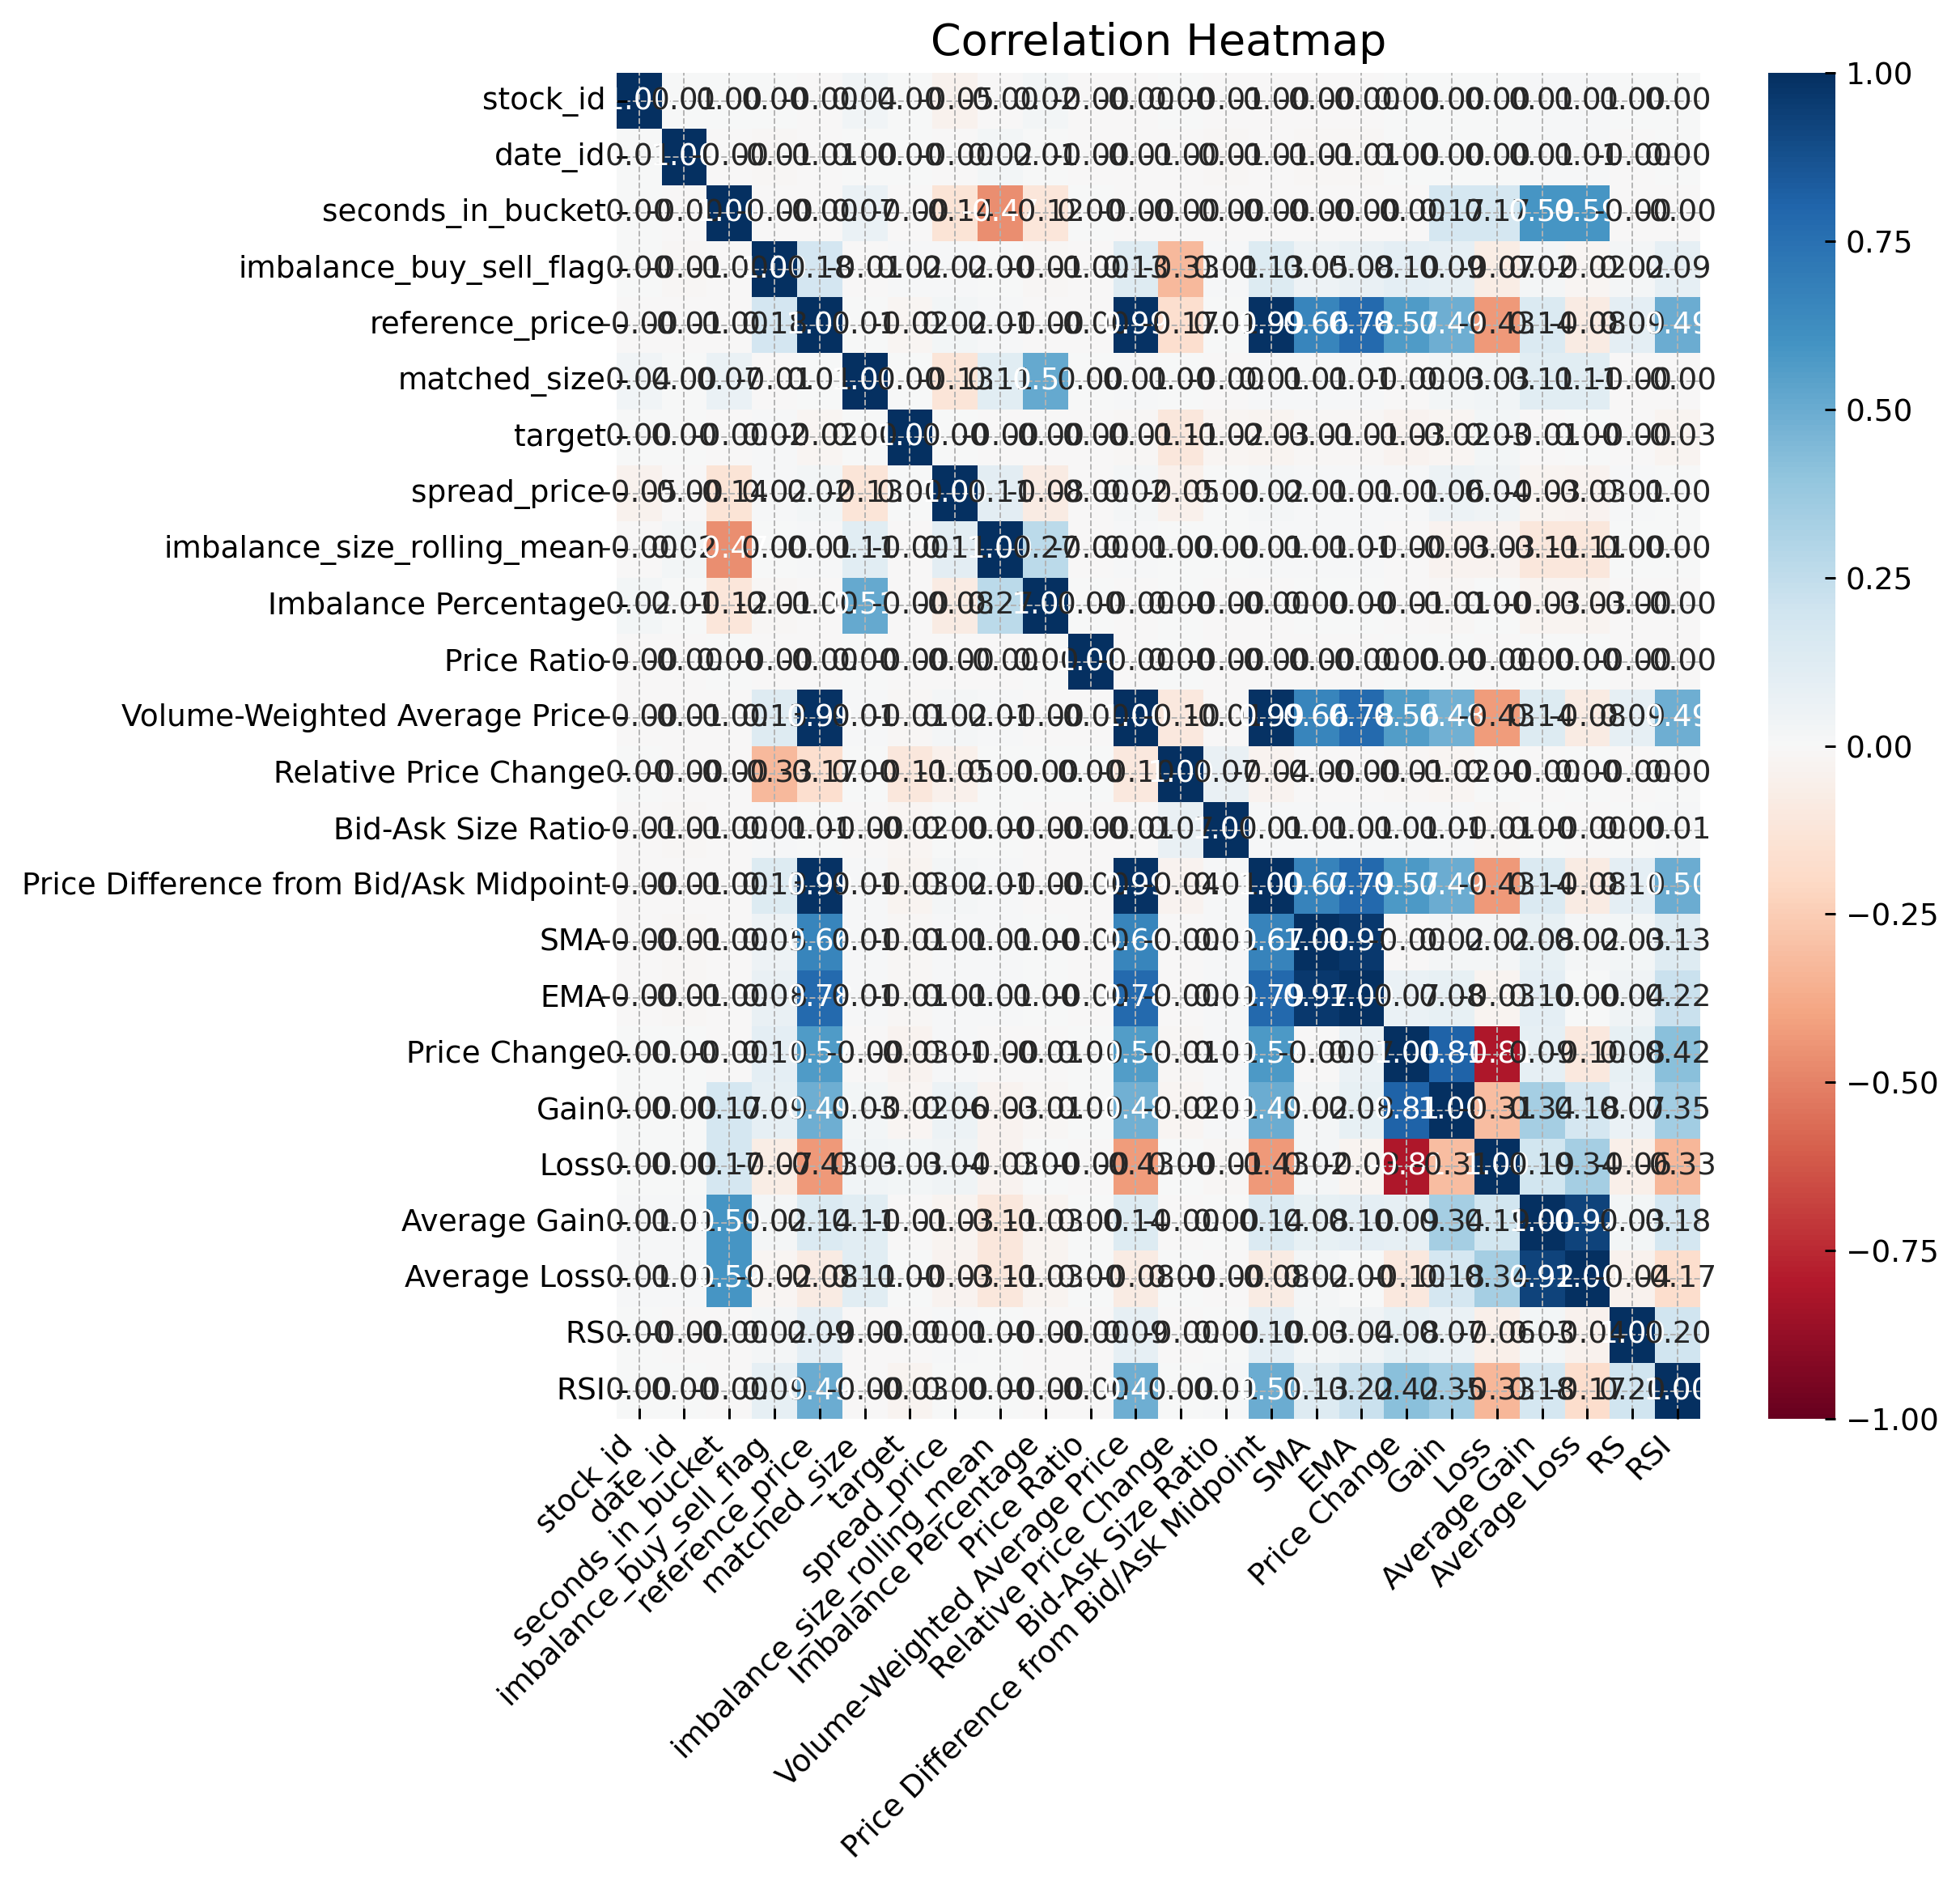

In [ ]:
# Plot correlation heatmap
corr_mat = train_df.corr()

plt.figure(figsize=(8,8))
heatmap = sns.heatmap(corr_mat, cmap='RdBu', annot=True, fmt='0.2f', center=0, vmin=-1, vmax=1)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Correlation Heatmap")
plt.show()

## Modeling

### Linear Regression

In [ ]:
# store features dataframe into "features" variable
#features = train_df.drop(columns='target')

# store the classification target variable into "target"
#target = train_df['target']

# assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
Seed = 5

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=Seed)

In [ ]:
# Initialize model with default parameters and fit it on the training set
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mae

6.3164220093194805

### Logistic Regression

In [ ]:
# Split the data
Seed = 5
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=Seed)

# Train Logistic Regression model
clf = LogisticRegression(penalty='l2', random_state=42, max_iter=5000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Generate confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(data=confmat, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])

# Plotting using seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.show()

### Linear Regression in Time-Series

In [ ]:
# TimeSeries Split for cross-validation
tscv = TimeSeriesSplit(n_splits=10)
mae_scores = []

for train_index, test_index in tscv.split(features):

    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    X_train = imputer.fit_transform(X_train)
    X_test = imputer.fit_transform(X_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

avg_mae = np.mean(mae_scores)

avg_mae

6.43216205643742

### PCA

In [ ]:
# assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
Seed = 5

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=Seed)

# intermediate step to address fac that PCA is not scale-invariant
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# instantiate and Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

PCA()

In [ ]:
# Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_

# Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = explained_variance_ratios.cumsum()

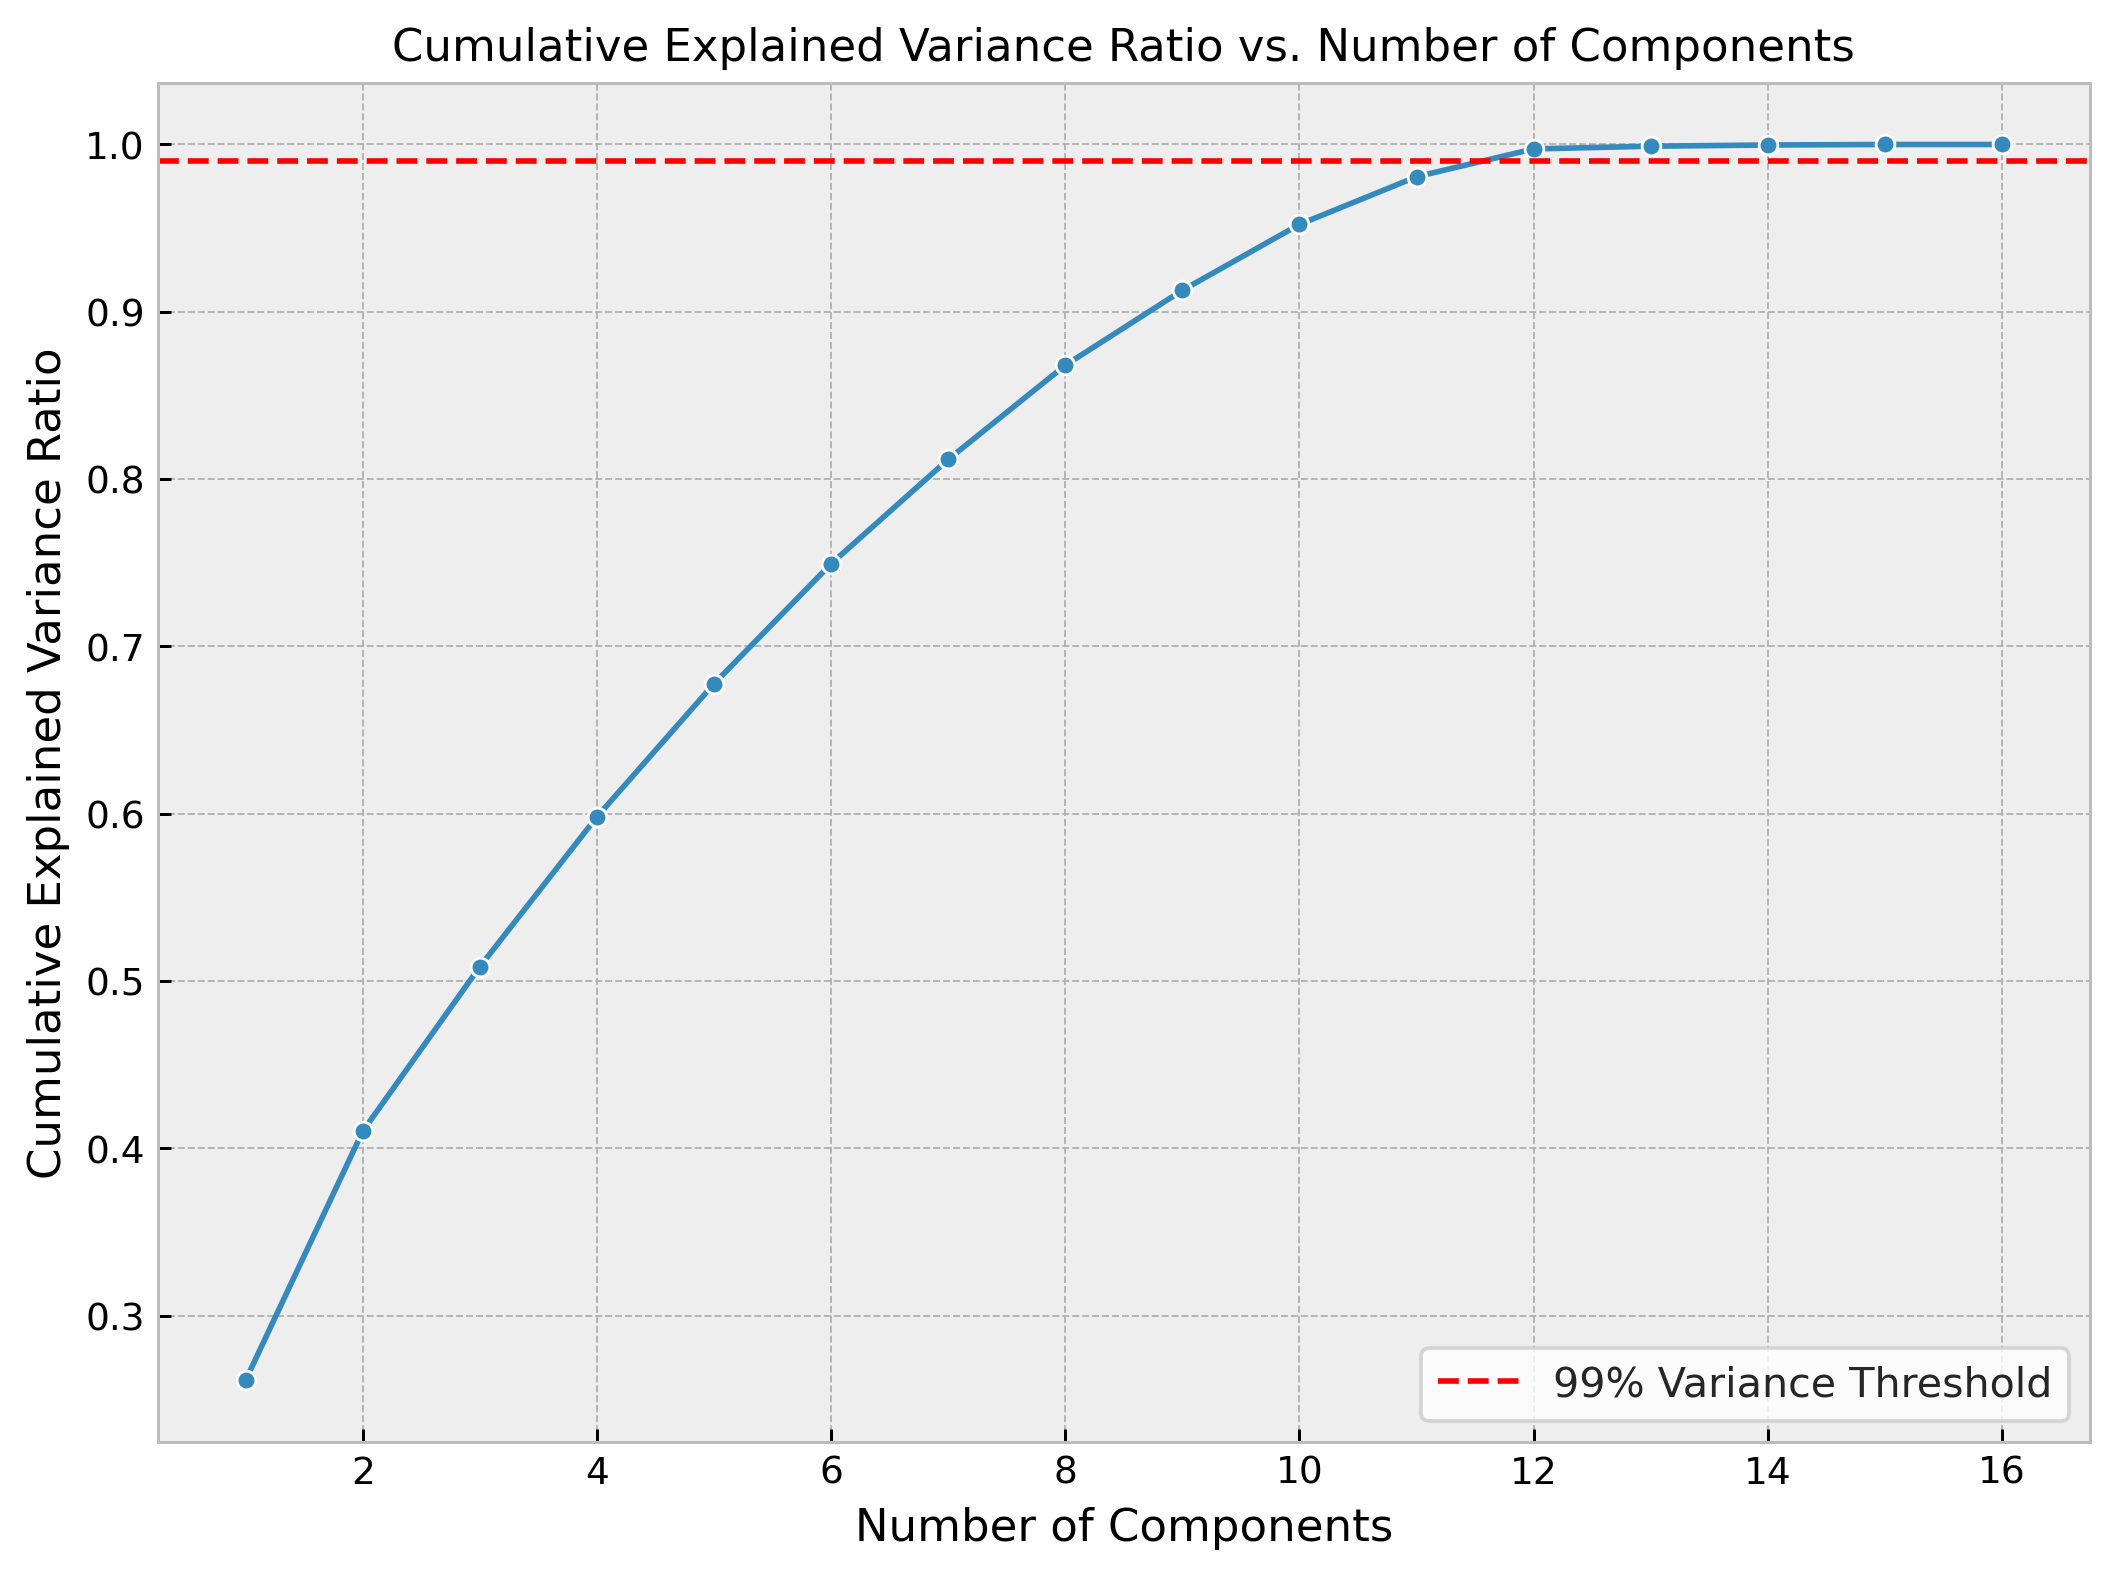

In [ ]:
# Find optimal num components to use (n) by plotting explained variance ratio
num_components = range(1, len(cum_evr)+1)
threshold = 0.99

fig, ax = plt.subplots(figsize=(8,6))
sns.set(style="whitegrid")

sns.lineplot(x=num_components, y=cum_evr, ax=ax, marker='o', markersize=5)
plt.axhline(y=0.99, color='red', linestyle='--', label='99% Variance Threshold')

ax.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance Ratio')
ax.set_title('Cumulative Explained Variance Ratio vs. Number of Components')

plt.legend()

plt.tight_layout()
plt.show()

#### Final PCA

In [ ]:
# Get transformed set of principal components on x_test

# 1. Refit and transform on training with parameter n (as deduced from the last step)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

n_pcs_99 = 12

pca = PCA(n_components=n_pcs_99)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set and store it as `X_test_pca`
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LinearRegression()
log_reg_pca.fit(X_train_pca, y_train)

# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = log_reg_pca.predict(X_test_pca)

# Find the mean absolute error and store the value in `mae`
mae = mean_absolute_error(y_test, y_pred)

mae

## Competition Submission

In [ ]:
# You can only call `make_env()` once per section.
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
# To count how many time the "for loop" runs.
counter = 0

# init 3 empty lists
test, revealed_targets, sample_prediction = [], [], []

for (test, revealed_targets, sample_prediction) in iter_test:
    # Append the dataframe that API return into the list.
    test.append(test.copy())
    revealed_targets.append(revealed_targets.copy())
    sample_prediction.append(sample_prediction.copy())

    # Writes our predictions (here, all predictions are 0s).
    sample_prediction["target"] = 0

    # This line submit our predictions.
    env.predict(sample_prediction)
    counter += 1

print('\n', '=' * 50, sep="")
print(f"counter: {counter}")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


<ipython-input-66-031db97a9a8f>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test.append(test.copy())
<ipython-input-66-031db97a9a8f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  revealed_targets.append(revealed_targets.copy())
<ipython-input-66-031db97a9a8f>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_prediction.append(sample_prediction.copy())
<ipython-input-66-031db97a9a8f>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test.append(test.copy())
<ipython-input-66-031db97a9a8f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


counter: 165


In [ ]:
revealed_targets[0]

In [ ]:
# timestamp for total run of the notebook
END = pd.Timestamp.now()
time_elapsed = (END - START).total_seconds()
print(f"Notebook Total Time: {time_elapsed:.2f}s")